# 01 — Load, QC, and Leveling (imu-sim → MAMMAL-ready)

Goal:
- Load imu-sim outputs (`sim_magnav.csv`, `trajectory.csv`)
- Sanity-check signals (time series + flight path)
- Prepare a MAMMAL-style `survey_df`
- Create synthetic flight-line labels (`line_id`)
- Run MAMMAL leveling (tie-line / PCA) and compare outputs


In [1]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
#loading csvs
SIM_DIR = "../data/sim_dataTL"

df = pd.read_csv(f"{SIM_DIR}/sim_magnav.csv")
traj = pd.read_csv(f"{SIM_DIR}/trajectory.csv")

print("sim_magnav rows:", len(df))
print("trajectory rows:", len(traj))
df.head()


sim_magnav rows: 148016
trajectory rows: 148016


,time_s,lat,lon,alt_m,mag_scalar_nT,mag_anomaly_injected_nT,mag_residual_nT
0,0.00,-27.116237,131.084472,100.0,55445.483869,-6.953404,35.695884
1,0.01,-27.116235,131.084472,100.0,55382.321804,-6.683435,-27.465100
2,0.02,-27.116233,131.084472,100.0,55415.597191,-6.412450,5.811368
3,0.03,-27.116232,131.084472,100.0,55378.849986,-6.140469,-30.934757
4,0.04,-27.116230,131.084472,100.0,55332.821138,-5.867511,-76.962524


In [3]:
#sanity checks
print("Columns:", df.columns.tolist())
print("time_s range:", df.time_s.min(), "→", df.time_s.max())

# Check monotonic time (should be increasing)
is_monotonic = np.all(np.diff(df.time_s.values) >= 0)
print("time_s monotonic:", is_monotonic)


Columns: ['time_s', 'lat', 'lon', 'alt_m', 'mag_scalar_nT', 'mag_anomaly_injected_nT', 'mag_residual_nT']
time_s range: 0.0 → 1480.15
time_s monotonic: True


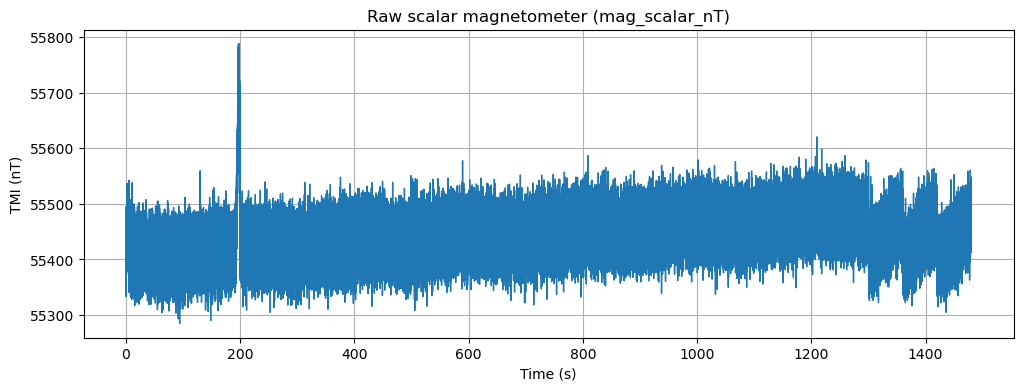

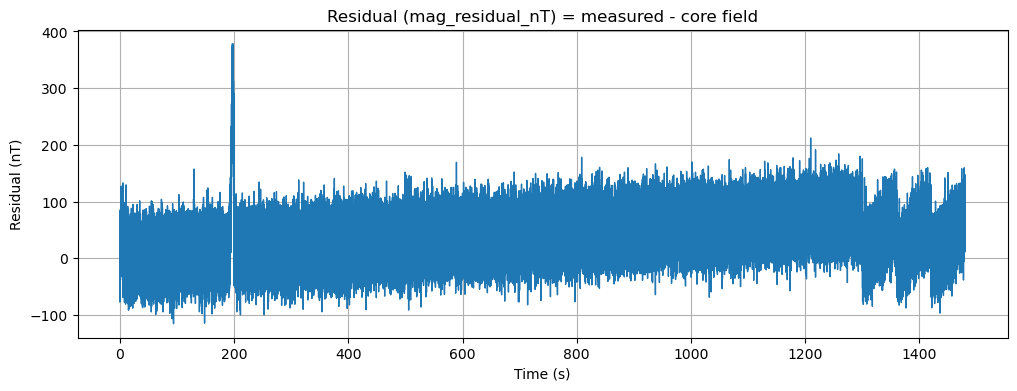

In [4]:
#plotting raw scalar values + residual vs time
plt.figure(figsize=(12,4))
plt.plot(df.time_s, df.mag_scalar_nT, linewidth=1)
plt.xlabel("Time (s)")
plt.ylabel("TMI (nT)")
plt.title("Raw scalar magnetometer (mag_scalar_nT)")
plt.grid(True)
plt.show()

plt.figure(figsize=(12,4))
plt.plot(df.time_s, df.mag_residual_nT, linewidth=1)
plt.xlabel("Time (s)")
plt.ylabel("Residual (nT)")
plt.title("Residual (mag_residual_nT) = measured - core field")
plt.grid(True)
plt.show()


Text(0.5, 1.0, 'Residual = anomaly + noise')

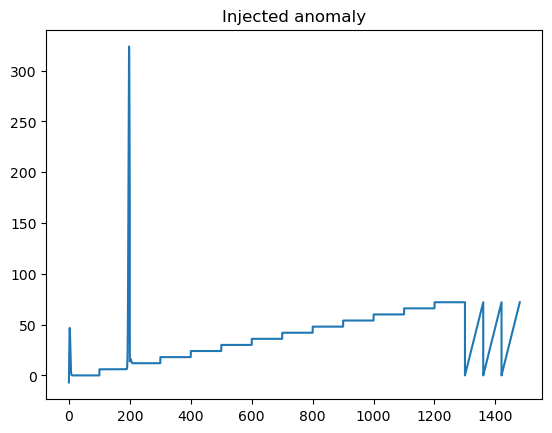

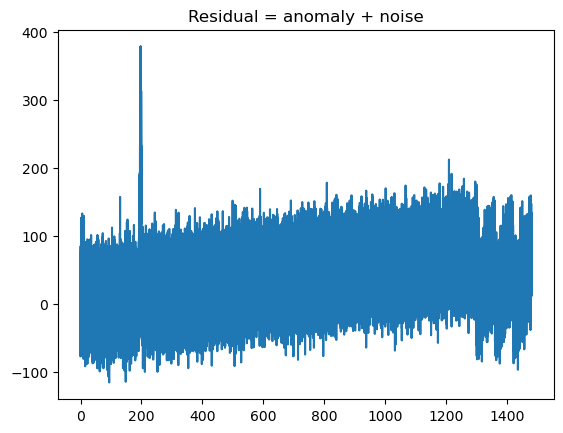

In [5]:
plt.figure()
plt.plot(df["time_s"], df["mag_anomaly_injected_nT"])
plt.title("Injected anomaly")

plt.figure()
plt.plot(df["time_s"], df["mag_residual_nT"])
plt.title("Residual = anomaly + noise")


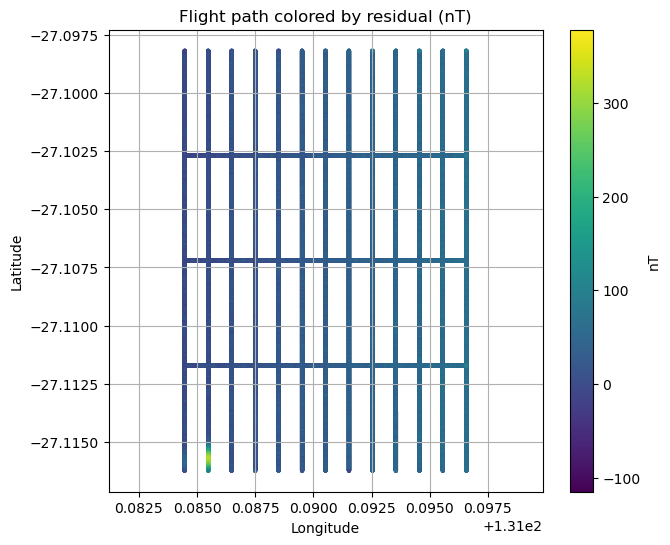

In [6]:
#plotting flight path colored by residual (for quick spatial intuition)
plt.figure(figsize=(7,6))
sc = plt.scatter(df.lon, df.lat, c=df.mag_residual_nT, s=4)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Flight path colored by residual (nT)")
plt.colorbar(sc, label="nT")
plt.axis("equal")
plt.grid(True)
plt.show()


In [7]:
import sys
!{sys.executable} -m pip install pymap3d


In [8]:
print("lat min/max:", df.lat.min(), df.lat.max())
print("lon min/max:", df.lon.min(), df.lon.max())
print("unique lat:", df.lat.nunique(), "out of", len(df))
print("unique lon:", df.lon.nunique(), "out of", len(df))
#dolat/lon
# how many repeats in a row?
same_pos = ((df.lat.diff().fillna(0)==0) & (df.lon.diff().fillna(0)==0)).mean()
print("Fraction of samples with identical lat/lon vs previous:", same_pos)


lat min/max: -27.116237 -27.098186786758287
lon min/max: 131.084472 131.09657455272065
unique lat: 147977 out of 148016
unique lon: 137977 out of 148016
Fraction of samples with identical lat/lon vs previous: 6.75602637552697e-06


#checkingENUreading

In [9]:
print("east range (m):", df.east_m.min(), df.east_m.max())
print("north range (m):", df.north_m.min(), df.north_m.max())


AttributeError: 'DataFrame' object has no attribute 'east_m'

find first index where motion occurs

In [ ]:
motion = np.sqrt(np.diff(df.east_m, prepend=df.east_m.iloc[0])**2 + np.diff(df.north_m, prepend=df.north_m.iloc[0])**2)
idx = np.argmax(motion > 0)  # first True index
print("first index with motion:", idx, "time:", df.time_s.iloc[idx], "motion step (m):", motion[idx])


first index with motion: 1002 time: 10.02 motion step (m): 9.999924356588917e-05


In [ ]:
import numpy as np

lat = df["lat"].to_numpy()
lon = df["lon"].to_numpy()

# Heading (bearing) from point i -> i+1, in degrees [0, 360)
heading = np.zeros(len(df))

lat1 = np.deg2rad(lat[:-1])
lat2 = np.deg2rad(lat[1:])
dlon = np.deg2rad(lon[1:] - lon[:-1])

x = np.sin(dlon) * np.cos(lat2)
y = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(dlon)

brng = np.rad2deg(np.arctan2(x, y))
heading[:-1] = (brng + 360) % 360
heading[-1] = heading[-2]  # copy last valid heading

df["heading_deg"] = heading


how much heading is changing

In [ ]:
h = df["heading_deg"].values
dhead = (np.diff(h, prepend=h[0]) + 180) % 360 - 180

print("Per-sample |dhead| stats (deg):")
print("  max:", np.nanmax(np.abs(dhead)))
print("  mean:", np.nanmean(np.abs(dhead)))
print("  95%:", np.nanpercentile(np.abs(dhead), 95))

print("Overall heading range:", np.nanmin(h), "→", np.nanmax(h))


Per-sample |dhead| stats (deg):
  max: 157.27712156585415
  mean: 0.020667926742242552
  95%: 1.6062483609857736e-06
Overall heading range: 0.0 → 359.999087734343


how to segment the tracks:
For each sample, we compute a forward-looking turn score equal to the absolute wrapped heading change over W samples. Samples exceeding a threshold are flagged as turning. Line segmentation is performed by incrementing the line index upon exiting a turn, so that each line ID corresponds to a straight traversal between successive turns.

In [ ]:
import numpy as np

h = df["heading_deg"].values  #converts pandas df to array

#heading is circular (0-360 degree) ->change to -180 to 180 range
def wrap_diff_deg(a, b):
    # wrapped difference a-b in [-180, 180]
    return ((a - b + 180) % 360) - 180

# Window length in samples.
# Your dt is 0.01s, so:
#   W=500  -> 5 seconds lookahead
#   W=1000 -> 10 seconds lookahead
W = 800  #W = 8s look ahead 8s to see how much the heading has changed

# Turn score = total heading change over W samples
turn_score = np.zeros(len(h)) #create array of 0s size h
for i in range(len(h) - W):
    turn_score[i] = abs(wrap_diff_deg(h[i + W], h[i]))  #change in heading in W samples - take abs only want magnitude

df["turn_score_deg"] = turn_score

# Threshold: how much heading rotation over W counts as "turn".
# For U-turns, you'll see near ~180 deg over the turn region.
turn_total_thresh = 45.0
is_turn = df["turn_score_deg"].values > turn_total_thresh   #true when turn_score > 45
df["is_turn"] = is_turn     #stores it in df as is_turn

# Create line_id: increment when we EXIT a turn
line_id = np.zeros(len(df), dtype=int)  #init all 0
current = 0     #current segment
in_turn_prev = df["is_turn"].iloc[0]   #turn-state of previous state

for i in range(1, len(df)):
    in_turn = df["is_turn"].iloc[i]        #get current turning state
    if in_turn_prev and not in_turn:    #detect if exiting a turn (stopped turning)
        current += 1                    #new segment
    line_id[i] = current                #new segment gets new line num
    in_turn_prev = in_turn              #update for next iteration

df["LINE"] = line_id             #save line id to dataframe

print("W:", W, "turn_total_thresh:", turn_total_thresh)
print("Num line segments:", df["LINE"].nunique())        #to count how many unique line_id exist


W: 800 turn_total_thresh: 45.0
Num line segments: 18


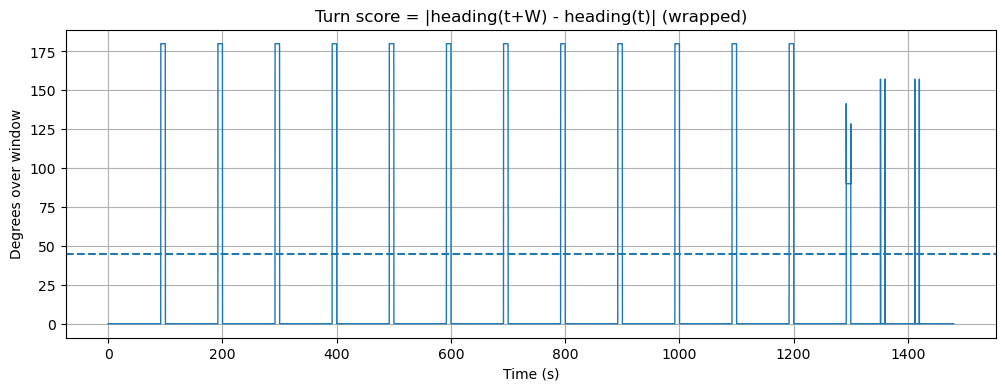

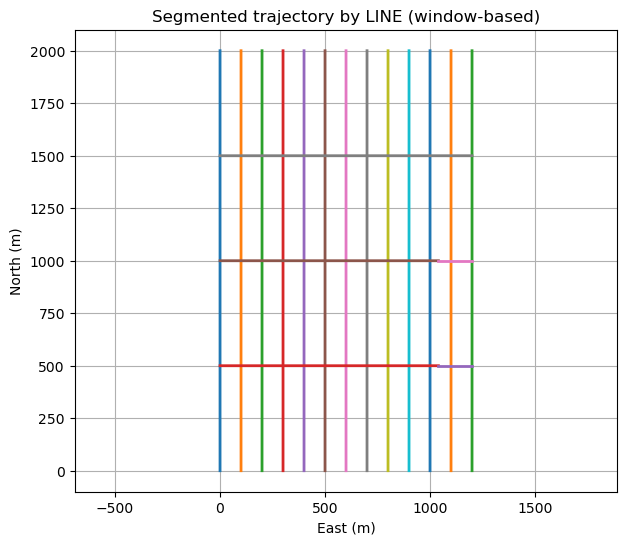

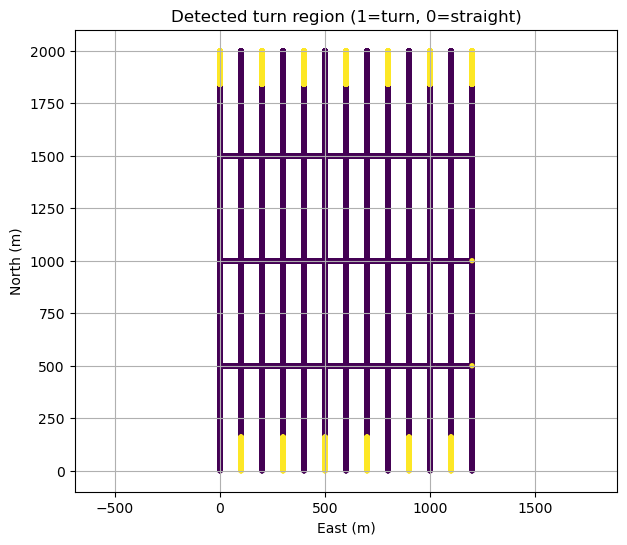

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pymap3d as pm

# --- Ensure ENU columns exist ---
if ("east_m" not in df.columns) or ("north_m" not in df.columns):
    lat = df["lat"].to_numpy()
    lon = df["lon"].to_numpy()
    lat0, lon0 = lat[0], lon[0]
    east, north, _ = pm.geodetic2enu(lat, lon, np.zeros_like(lat), lat0, lon0, 0)
    df["east_m"] = east
    df["north_m"] = north

# Use the same threshold you used in segmentation
turn_total_thresh = 45.0  # change if you used a different value

# 1) Turn score vs time
plt.figure(figsize=(12,4))
plt.plot(df["time_s"], df["turn_score_deg"], linewidth=1)
plt.axhline(turn_total_thresh, linestyle="--")
plt.title("Turn score = |heading(t+W) - heading(t)| (wrapped)")
plt.xlabel("Time (s)")
plt.ylabel("Degrees over window")
plt.grid(True)
plt.show()

# 2) Segmented ENU trajectory
plt.figure(figsize=(7,6))
for lid, g in df.groupby("LINE"):
    plt.plot(g["east_m"], g["north_m"], linewidth=2)
plt.title("Segmented trajectory by LINE (window-based)")
plt.xlabel("East (m)")
plt.ylabel("North (m)")
plt.axis("equal")
plt.grid(True)
plt.show()

# 3) Turn points on ENU plot
plt.figure(figsize=(7,6))
plt.scatter(df["east_m"], df["north_m"], c=df["is_turn"].astype(int), s=8)
plt.title("Detected turn region (1=turn, 0=straight)")
plt.xlabel("East (m)")
plt.ylabel("North (m)")
plt.axis("equal")
plt.grid(True)
plt.show()


how many samples in each segment - to check if segments are mostly uniform

In [ ]:
seg_counts = df.groupby("LINE").size()
print(seg_counts)


LINE
0     10001
1     10001
2     10001
3     10001
4     10001
5     10001
6     10001
7     10001
8     10001
9     10001
10    10001
11    10001
12    10001
13     5201
14      800
15     5201
16      800
17     6001
dtype: int64


put output in new csv 

In [ ]:
# ---- Persist line segmentation into a new CSV ----
out_path = "../data/sim_dataTL/sim_magnav_with_lines.csv"  # update folder if needed

# Ensure LINE is int
df["LINE"] = df["LINE"].astype(int)

# Add a string line label (some MAMMAL code expects 'line')
df["line"] = df["LINE"].astype(str)

df.to_csv(out_path, index=False)
print("Saved:", out_path)
print("Num lines:", df["LINE"].nunique())
print("Columns now:", df.columns.tolist())


Saved: ../data/sim_dataTL/sim_magnav_with_lines.csv
Num lines: 18
Columns now: ['time_s', 'lat', 'lon', 'alt_m', 'mag_scalar_nT', 'mag_anomaly_injected_nT', 'mag_residual_nT', 'heading_deg', 'turn_score_deg', 'is_turn', 'LINE', 'east_m', 'north_m', 'line']
